Grupo: Gabriela Cristina Moreira dos Santos,
       Lucas Guilherme Silva de Carvalho

---

#**Reconhecimento facial em risco: Vulnerabilidades e defesas contra ataques adversariais.**

# **Geração de imagens de rostos humanos usando uma Rede Generativa Adversarial (GAN)**


---


Este código tem como meta treinar uma Rede Generativa Adversarial (GAN) para criar imagens realistas de rostos humanos usando o conjunto de dados LFW. A GAN é composta por dois componentes: o gerador, que produz imagens sintéticas, e o discriminador, que aprende a distinguir entre as imagens verdadeiras e as geradas. Durante o treinamento, o gerador tenta enganar o discriminador com imagens cada vez mais realistas e o discriminador se esforça para diferenciar entre as reais e as falsas.

O código inicia com o download do conjunto de dados LFW, estabelece os modelos do gerador e discriminador, e define as funções de perda e otimizadores para treinar ambos. Ao longo das épocas de treinamento, ajusta-se os pesos dos modelos e periodicamente são exibidas as imagens geradas e as probabilidades do discriminador. Ao concluir o treinamento, o código mostra as imagens produzidas pelo gerador. Portanto, o propósito final deste código é treinar uma GAN para produzir imagens de rostos humanos indistinguíveis das reais utilizando o conjunto de dados LFW.

### **Bibliotecas**

In [ ]:
# Importando Bibliotecas
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from skimage.transform import resize
import tarfile
import sys
sys.path.append("..")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations, layers, losses, optimizers, regularizers

###**Acompanhamento visual do progresso do código**

#### **Código**

In [ ]:
# Indicação visual do progresso do código
def progress(iterable, every=1):
    for index, item in enumerate(iterable):
        if index % every == 0: print("*", end="")
        yield item
    print(".")

#### **Explicação**

A função de utilidade chamada **progress** serve para acompanhar o progresso de um iterável (como um loop) exibindo um símbolo de estrela a cada iteração. Essa função é útil para fornecer uma indicação visual do progresso do código, especialmente quando se lida com iterações longas ou processamentos intensivos.

### **Leitura e pré-processamento de imagens**

#### **Código**

In [ ]:
# Lendo Imagens
def read_images(arch_path, crop_x=80, crop_y=80, size_x=90, size_y=90):
    with tarfile.open(arch_path) as arch:
        for entry in arch.getmembers():
            if entry.isfile() and entry.name.endswith(".jpg"):
                image = plt.imread(arch.extractfile(entry))
                image = image[crop_x : -crop_x, crop_y : -crop_y, : ]
                image = resize(image, (size_x, size_y))
                yield image

####**Explicação**

A função **read_images** é um gerador que itera sobre os membros (arquivos) presentes no arquivo tar. Ele verifica se cada membro é um arquivo e se tem a extensão ".jpg". Em seguida, utiliza a função plt.imread para ler a imagem em formato de matriz.

Após ler a imagem, o código aplica duas operações principais nessa imagem:

* Operação de corte: É aplicado um corte nas bordas da imagem, removendo uma quantidade especificada de pixels de cada lado. Isso ajuda a remover informações desnecessárias ou bordas indesejadas da imagem.

* Operação de redimensionamento: A imagem é redimensionada para um tamanho especificado (36x36 pixels no código fornecido). A função resize do skimage.transform é usada para redimensionar a imagem para as dimensões desejadas.

Após o corte e redimensionamento, a imagem processada é retornada como resultado do gerador.


### **Baixando o Conjunto de Dados**

####**Código**

In [ ]:
lfw_url = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
lfw_path = "lfw-deepfunneled.tgz"

keras.utils.get_file(lfw_path, lfw_url, cache_dir=".", cache_subdir="")

print("Extraindo Imagens: ", end="")
data = np.float32([ image for image in progress(read_images(lfw_path, size_x=36, size_y=36), every=200) ])

Extraindo Imagens: *******************************************************************.


#### **Explicação**

Essa parte do código realiza o download do conjunto de dados LFW, extrai as imagens do arquivo baixado e as armazena no array data. As imagens são redimensionadas para um tamanho de 36x36 pixels antes de serem processadas.

### **Visualização das Imagens Processadas**

####**Código**

Dimensões da imagem : (36, 36, 3)
Total de Imagens: 13233


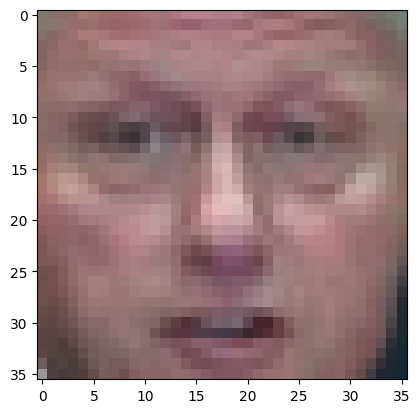

In [ ]:
IMAGE_SHAPE = data.shape[1 : ]

print("Dimensões da imagem :", IMAGE_SHAPE)
print("Total de Imagens:", len(data))
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

#### **Explicação**

Esse trecho de código imprime o formato das imagens processadas, o número total de imagens e exibe uma imagem aleatória do conjunto de dados.

### **Modelo do Gerador**

####**Código**

In [ ]:
CODE_SIZE = 256

def generator():
  model = keras.Sequential()
  model.add(layers.Input(shape=(CODE_SIZE,), name='code'))
  model.add(layers.Dense(6*6*32, activation='elu'))
  model.add(layers.Reshape((6,6,32)))
  model.add(layers.Conv2DTranspose(128, kernel_size=5, activation='elu'))
  model.add(layers.Conv2DTranspose(128, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(64, kernel_size=3, activation='elu'))
  model.add(layers.UpSampling2D())
  model.add(layers.Conv2DTranspose(64, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(32, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(32, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(3, kernel_size=3))
  return model

#### **Explicação**

O código define uma função chamada generator que cria o modelo do gerador usando a API Sequencial do Keras. Ele consiste em várias camadas, incluindo camadas densas, de remodelagem, de convolução transposta, de aumento de amostragem e de convolução. O modelo recebe um código de entrada e gera uma imagem como saída.

### **Modelo do Discriminador**

#### **Código**

In [ ]:
def discriminator():
  model = keras.Sequential()
  model.add(layers.Input(shape=IMAGE_SHAPE, name="image"))
  model.add(layers.Conv2D(32, kernel_size=3, activation='elu'))
  model.add(layers.Conv2D(32, kernel_size=5, activation='elu'))
  model.add(layers.Conv2D(64, kernel_size=3, activation='elu'))
  model.add(layers.MaxPool2D())
  model.add(layers.Conv2D(64, kernel_size=3, activation='elu'))
  model.add(layers.Conv2D(128, kernel_size=5, activation='elu'))
  model.add(layers.Conv2D(128, kernel_size=3, activation='elu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2()))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

#### **Explicação**

O código define uma função chamada discriminator que cria o modelo do discriminador usando a API Sequencial do Keras. Ele consiste em camadas de convolução, de max pooling, de achatamento, densas e de saída. O modelo recebe uma imagem como entrada e faz uma previsão se é real ou gerada.

### **Inicializar modelo discriminador**

#### **Código**

In [ ]:
# Limpar a sessão do TensorFlow/Keras
keras.backend.clear_session()

In [ ]:
# Inicializar o modelo gerador
gen = generator()
gen.summary()
print("Entradas :", gen.inputs)
print("Saídas:", gen.outputs)

assert gen.output_shape[1:] == IMAGE_SHAPE, "o gerador deve produzir uma imagem com formato %s, mas está produzindo uma imagem com formato %s"%(IMAGE_SHAPE,gen.output_shape[1:])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1152)              296064    
                                                                 
 reshape (Reshape)           (None, 6, 6, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 10, 128)      102528    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 12, 12, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 64)       73792     
 ranspose)                                                       
                                                        

In [ ]:
# Inicializar o modelo discriminador
disc = discriminator()

disc.summary()
print("Inputs :", disc.inputs)
print("Outputs:", disc.outputs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 34, 34, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         204928    
                                                      

#### **Explicação**

Essa parte do código inicializa e analisa os modelos gerador e discriminador. É realizada a verificação das dimensões e formatos de entrada e saída dos modelos, garantindo que estejam corretos antes do treinamento da Rede Generativa Adversarial (GAN).

---


## Treinamento


---



### **Definição das funções de perda (loss) para o treinamento da GAN**

####**Código**

In [ ]:
# Definição das funções de perda (loss) para o treinamento da GAN
def create_discriminator_loss(g, d):
    return lambda images, codes: -tf.math.reduce_mean(
        tf.math.log( d(images) ) + tf.math.log( 1 - d(g(codes)) )
    )

def create_generator_loss(g, d):
    return lambda codes: -tf.math.reduce_mean(tf.math.log( d(g(codes)) ))

In [ ]:
# Estabelecer os otimizadores e funções de perda para treinar a GAN
disc_opt = optimizers.SGD(1e-3)
disc_loss = create_discriminator_loss(gen, disc)

gen_opt = optimizers.Adam(1e-4)
gen_loss = create_generator_loss(gen, disc)

#### **Explicação**

Essas duas funções determinam as funções de perda (loss) para treinar a GAN, especificamente para o discriminador e o gerador.

**create_discriminator_loss(g, d):** Esta função define a perda do discriminador. Utilizando o gerador g e o discriminador d, ela cria uma função lambda para calcular a perda com base em imagens reais e códigos de entrada. Esta perda é a média do logaritmo das probabilidades que o discriminador atribui a imagens reais e às geradas pelo gerador. A perda é negativa para maximizar a chance do discriminador classificar corretamente as imagens.

* **create_generator_loss(g, d):** Esta função estabelece a perda do gerador. Utilizando o gerador g e o discriminador d, cria uma função lambda que calcula a perda com base nos códigos de entrada. A perda é a média do logaritmo da probabilidade que o discriminador dá às imagens geradas pelo gerador. A perda é negativa para maximizar a probabilidade do gerador de enganar o discriminador, ou seja, de produzir imagens que o discriminador classifica como reais.

* **disc_opt = optimizers.SGD(1e-3):** Cria um otimizador para o discriminador com o algoritmo SGD e taxa de aprendizado de 0,001. Este otimizador ajustará os parâmetros do discriminador durante o treinamento.

* **disc_loss = create_discriminator_loss(gen, disc):** Define a função de perda para o discriminador, usando a função create_discriminator_loss com o gerador e discriminador como argumentos. Esta função será usada para calcular a perda do discriminador durante o treinamento.

* **gen_opt = optimizers.Adam(1e-4):** Estabelece um otimizador para o gerador com o algoritmo Adam e taxa de aprendizado de 0,0001. Este otimizador ajustará os parâmetros do gerador durante o treinamento.

* **gen_loss = create_generator_loss(gen, disc):** Define a função de perda para o gerador, usando a função create_generator_loss com o gerador e o discriminador como argumentos. Esta função será usada para calcular a perda do gerador durante o treinamento.

As funções são cruciais para determinar as perdas corretas durante o treinamento da GAN. A perda do discriminador visa maximizar a classificação correta de imagens reais e falsas, enquanto a perda do gerador visa enganar o discriminador para produzir imagens mais realistas.

### **Visualização e análise dos resultados da GAN**

####**Código**

In [ ]:
def sample_codes(batch_size):
    # Gera códigos de entrada aleatórios para o gerador
    return np.float32(np.random.normal(size=(batch_size, CODE_SIZE)))

def sample_images(batch_size):
    # Amostra imagens aleatórias do conjunto de dados
    return data[np.random.choice(len(data), size=batch_size)]

def plot_images(nrow, ncol):
    # Gera e exibe uma grade de imagens geradas pelo modelo gerador
    preds = gen.predict(sample_codes(nrow * ncol)) # Gera códigos de entrada e obtém as previsões do gerador

    for i in range(nrow * ncol):
        plt.subplot(nrow, ncol, i + 1) # Cria um subplot na grade
        plt.imshow(preds[i].clip(0., 1.), interpolation="none") # Exibe a imagem gerada
        plt.axis("off") # Desativa as marcações do eixo
    plt.show() # Exibe a grade de imagens geradas

def plot_probas(size):
    # Gera e exibe histogramas das probabilidades de classificação do discriminador
    real_probs = disc.predict(sample_images(size)) # Calcula as probabilidades para as imagens reais
    gen_probs = disc.predict(gen.predict(sample_codes(size))) # Calcula as probabilidades para as imagens geradas

    plt.hist(real_probs, range=(0, 1), alpha=0.5, label="D(x)") # Histograma das probabilidades das imagens reais
    plt.hist(gen_probs, range=(0, 1), alpha=0.5, label="D(G(x))") # Histograma das probabilidades das imagens geradas
    plt.legend() # Exibe a legenda
    plt.show() # Exibe os histogramas

####**Explicação**

Essas funções são responsáveis por amostrar códigos de entrada, amostrar imagens do conjunto de dados, gerar e exibir imagens sintéticas geradas pelo modelo gerador, e calcular e exibir histogramas das probabilidades de classificação do discriminador para as imagens reais e geradas. Essas funções são úteis para visualizar e analisar os resultados do treinamento da GAN.

### **Salvamento de checkpoints do treinamento da GAN no Google Drive**

In [ ]:
from google.colab import drive
import os

drive.mount("/content/drive")

checkpoint_folder = "/content/drive/My Drive/1-R2LIVXdS-xQZUfmmESTzer2QLenCF5m/checkpoints"
os.makedirs(checkpoint_folder, exist_ok=True)
os.chdir(checkpoint_folder)

Mounted at /content/drive


### **Gerenciamento e restauração de checkpoints durante o treinamento da GAN**

#### **Código**

In [ ]:
epoch = tf.Variable(0)

ckpt = tf.train.Checkpoint(epoch=epoch, disc=disc, gen=gen, disc_opt=disc_opt, gen_opt=gen_opt)
manager = tf.train.CheckpointManager(ckpt, directory=checkpoint_folder, max_to_keep=10)

status = ckpt.restore(manager.latest_checkpoint)

#### **Explicação**

Essas linhas de código são responsáveis por criar objetos Checkpoint e CheckpointManager para gerenciar e restaurar os checkpoints durante o treinamento. Isso permite que você salve periodicamente o estado do treinamento e, se necessário, retome o treinamento a partir do último ponto salvo, evitando a perda de progresso e permitindo a continuação do treinamento de forma incremental.

### **Treinamento da GAN e Monitoramento do Progresso**

#### **Código**

Epoch: 29900


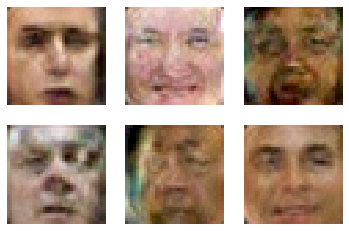

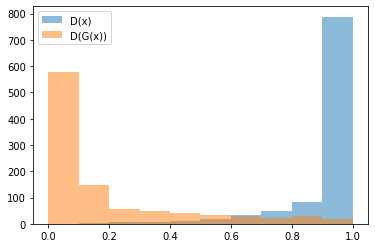

***************************************************************************************************.


In [ ]:
for _ in progress(range(30000)):
    # Amostra códigos de entrada e imagens para o treinamento
    codes = sample_codes(100)
    images = sample_images(100)

    for n in range(5):
        # Treina o discriminador por 5 iterações
        disc_opt.minimize(lambda: disc_loss(images, codes), disc.trainable_weights)

    # Treina o gerador
    gen_opt.minimize(lambda: gen_loss(codes), gen.trainable_weights)

    if epoch.numpy() % 100 == 0:
        display.clear_output(wait=True)

        print("Epoch:", epoch.numpy())
        # Gera e exibe uma grade de imagens geradas pelo gerador
        plot_images(2, 3)
        # Gera e exibe histogramas das probabilidades de classificação do discriminador
        plot_probas(1000)
        # Salva os checkpoints do treinamento
        manager.save()

    # Incrementa o número de épocas
    epoch.assign_add(1)


Results after 30000 epochs:


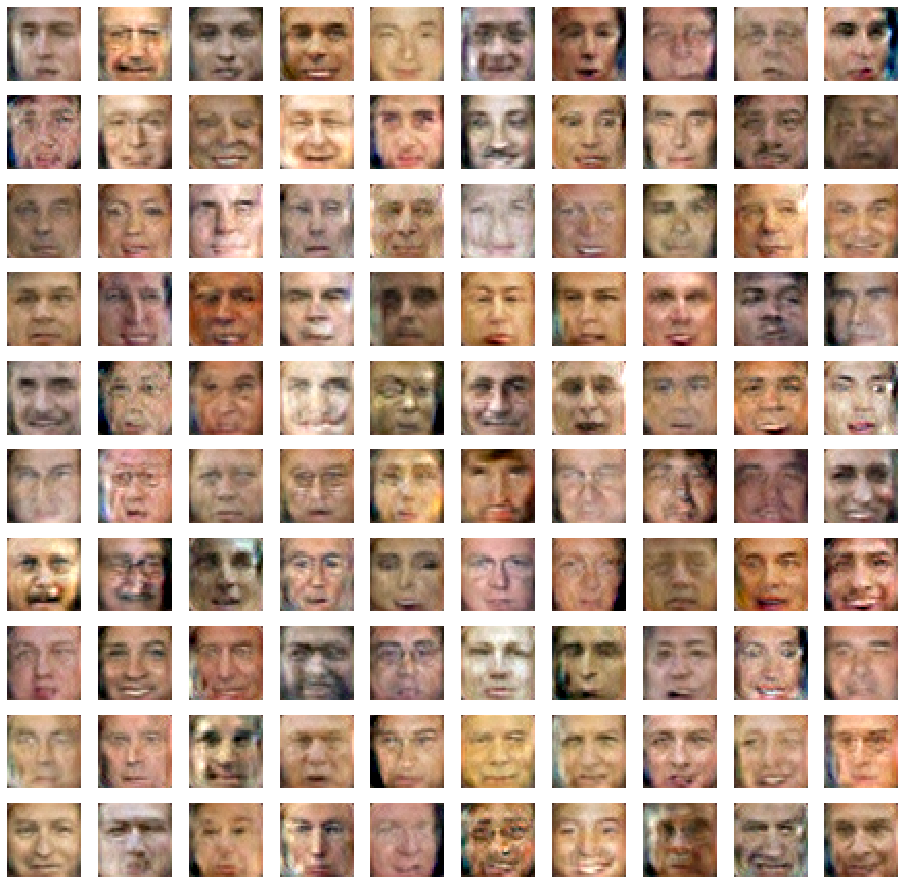

In [ ]:
# Exibem os resultados após um certo número de épocas de treinamento e geram uma grade visual de imagens.
print("Results after", epoch.numpy(), "epochs:")
plt.figure(figsize=[16, 16])
plot_images(10, 10)

#### **Explicação**

Nessa parte do código, é realizado o **treinamento da GAN** por um determinado número de épocas ou iterações. Durante o treinamento, o discriminador e o gerador são treinados alternadamente, sendo otimizados por meio da minimização das funções de perda. Além disso, o código monitora o progresso do treinamento exibindo e salvando periodicamente os resultados, como a geração de imagens pelo gerador e histogramas das probabilidades de classificação do discriminador. Esse monitoramento é importante para avaliar a evolução do treinamento e a qualidade das imagens geradas pela GAN.


---

O **histograma** produzido pelo código visualiza as probabilidades de classificação do discriminador para imagens reais e geradas.
O histograma mostra a distribuição das probabilidades. São gerados dois conjuntos: um para imagens reais (D(x)) e outro para imagens geradas pelo gerador (D(G(x))).
Ao comparar os histogramas de D(x) e D(G(x)), podemos avaliar a habilidade do discriminador em distinguir imagens reais das geradas. A sobreposição dos histogramas indica que o gerador está criando imagens realistas, enquanto a separação indica que o discriminador está distinguindo eficazmente as imagens reais das geradas.
Portanto, o histograma é uma ferramenta visual útil para avaliar a eficácia do discriminador e a qualidade das imagens geradas pela GAN.